# Data Import

In [1]:
# %%capture
# !pip install scikit-learn
# !pip install fancyimpute
# !pip install xgboost
# !pip install graphviz
# !pip install GPyOpt

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import pandas as pd
import numpy as np
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import plot_confusion_matrix
import graphviz
from fancyimpute import IterativeImputer
import shap
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import SelectFromModel
from numpy import sort
from xgboost import XGBClassifier
from xgboost import plot_importance
from fancyimpute import IterativeImputer
from bayes_opt import BayesianOptimization
import xgboost as xgb
from sklearn.metrics import mean_squared_error

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-27wr269c because the default path (/gpfs/home/pandik01/.config/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [4]:
df = pd.read_csv('/gpfs/data/proteomics/projects/pandik01/cleaned_data_09_08_2021.csv')

In [5]:
#changing cols with mixed dtypes to single dtype 
df.astype({df.columns[10]:'str', df.columns[11]:'str', df.columns[38]:'str'})

df.shape

(31580, 415)

In [6]:
col_names = ['Patient.Age', 'AGE_AT_DELIVERY', 'Gravida', 'Para', 'Term', 'Preterm', 'Abortions', 
             'Living.at.Delivery.Ct', 'RACE_White', 'RACE_African_American', 'RACE_Asian', 
             'RACE_Native_Hawaiian_or_Other_Pacific_Islander', 'RACE_Other_Race', 
             'ETHNICITY_Not_of_Spanish_Hispanic_Origin','ETHNICITY_Patient_Refused', 
             'ETHNICITY_Unknown', 'R.BMI', 'GA_IN_DAYS', 'Insulin', 'Insulin.NPH', 'Insulin.aspart', 'Insulin.detemir',
             'Insulin.glargine','Insulin.lispro','Insulin.regular', 'Oral.glycemic','GLUCOSE.CHALLENGE..PREGNANCY',
             'GLUCOSE.TOLERANCE.TEST.1.HOUR','GLUCOSE.TOLERANCE.TEST.2.HOUR','GLUCOSE.TOLERANCE.TEST.3.HOUR',
            'HEMOGLOBIN_FIRST_TRIMESTER','HEMOGLOBIN_SECOND_TRIMESTER','HEMOGLOBIN_THIRD_TRIMESTER',
             'PMH_Macrosomia_or_LGA', 'Macrosomia','IUGR','IUFD_or_demise','Grand_multip','Apgar.1','Apgar.5',
             'Apgar.10','Baby.Sex']
df = df[col_names]
        

In [7]:
#remaining features with NaN values
df.columns[df.isna().sum()!=0]

Index(['Patient.Age', 'AGE_AT_DELIVERY', 'Gravida', 'Para', 'Term', 'Preterm',
       'Abortions', 'Living.at.Delivery.Ct', 'R.BMI', 'GA_IN_DAYS',
       'GLUCOSE.CHALLENGE..PREGNANCY', 'GLUCOSE.TOLERANCE.TEST.1.HOUR',
       'GLUCOSE.TOLERANCE.TEST.2.HOUR', 'GLUCOSE.TOLERANCE.TEST.3.HOUR',
       'HEMOGLOBIN_FIRST_TRIMESTER', 'HEMOGLOBIN_SECOND_TRIMESTER',
       'HEMOGLOBIN_THIRD_TRIMESTER', 'Apgar.1', 'Apgar.5', 'Apgar.10',
       'Baby.Sex'],
      dtype='object')

In [8]:
#combining 'Patient.Age' and 'AGE_AT_DELIVERY' columns to fill NaN

#converting dtype to int for both columns
df['Patient.Age'] = df['Patient.Age'].fillna(0).astype(int)
df['AGE_AT_DELIVERY'] = df['AGE_AT_DELIVERY'].fillna(0).astype(int)

#replacing NaN values in 'Patient.Age' using 'AGE_AT_DELIVERY' values
df.iloc[:,:1] = df['AGE_AT_DELIVERY'].combine_first(df['Patient.Age'])

#dropping one of two age descriptors
df = df.drop(columns = 'Patient.Age') #redundant

#confirming no NaN values in Patient.Age
df[df['AGE_AT_DELIVERY'].isnull()]

,AGE_AT_DELIVERY,Gravida,Para,Term,Preterm,Abortions,Living.at.Delivery.Ct,RACE_White,RACE_African_American,RACE_Asian,...,HEMOGLOBIN_THIRD_TRIMESTER,PMH_Macrosomia_or_LGA,Macrosomia,IUGR,IUFD_or_demise,Grand_multip,Apgar.1,Apgar.5,Apgar.10,Baby.Sex


In [9]:
## remaining features with NaN values
# df.isna().sum()

In [10]:
#dropping all columns where most entries are NaN (>50%)
df = df.dropna(axis=1, thresh = 15000)

#remaining features with NaN values
df.shape

(31580, 34)

# Data Preprocessing

In [11]:
#imputing NaN values, outputs np array
imp = IterativeImputer()
array_imp = imp.fit_transform(df)

In [12]:
#converting np array back to df
cols = df.columns
df_imp = pd.DataFrame(np.array(array_imp), columns = cols)
df_imp.head()

,AGE_AT_DELIVERY,Gravida,Para,Term,Preterm,Abortions,Living.at.Delivery.Ct,RACE_White,RACE_African_American,RACE_Asian,...,Oral.glycemic,HEMOGLOBIN_THIRD_TRIMESTER,PMH_Macrosomia_or_LGA,Macrosomia,IUGR,IUFD_or_demise,Grand_multip,Apgar.1,Apgar.5,Baby.Sex
0,36.0,3.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,14.1,0.0,0.0,0.0,0.0,0.0,7.0,9.0,1.0
1,36.0,3.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,14.1,0.0,0.0,0.0,0.0,0.0,9.0,9.0,1.0
2,30.0,3.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,...,0.0,12.4,0.0,0.0,0.0,0.0,0.0,8.0,9.0,1.0
3,31.0,4.0,3.0,3.0,0.0,0.0,2.0,1.0,0.0,0.0,...,0.0,13.7,0.0,0.0,0.0,0.0,0.0,9.0,9.0,0.0
4,40.0,4.0,2.0,2.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,12.8,0.0,0.0,0.0,0.0,0.0,9.0,9.0,0.0


In [13]:
#replacing spaces in df with underscores
df_imp.replace(' ', '_', regex=True, inplace=True)

#replacing spaces and periods in column names with underscores (necessary for plotting tree later on)
df_imp.columns = df_imp.columns.str.replace(' ', '_')
df_imp.columns = df_imp.columns.str.replace('.', '_')

In [14]:
#sorting by incidence of macrosomia
df_imp = df_imp.sort_values(by=['Macrosomia'])

#resetting index
df_imp = df_imp.reset_index()

#subsampling top 250 (No Macrosomia) and bottom 248 (Macrosomia)
df_no_mac = df_imp.iloc[0:250,:]
df_mac = df_imp.iloc[-249:-1,:]

#verifying counts of each label category
print(df_no_mac['Macrosomia'].value_counts())
print(df_mac['Macrosomia'].value_counts())

0.0    250
Name: Macrosomia, dtype: int64
1.0    248
Name: Macrosomia, dtype: int64


In [15]:
#concatenating dfs
df_imp = pd.concat([df_no_mac, df_mac])

#removing index column
df_imp = df_imp.drop('index', axis = 1)

In [16]:
# df_imp.dtypes

# Splitting Data

In [17]:
#creating featuers variable by removing Macrosomia column
X = df_imp.drop('Macrosomia', axis = 1).copy()

#creating labels variable using Macrosomia column
y = pd.DataFrame(df_imp['Macrosomia'])

In [18]:
#splitting data into train/validation/test (60/20/20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle = True, stratify=y)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.25, random_state=42, shuffle = True, stratify = y_train)

In [19]:
X_train.shape

(298, 33)

In [20]:
X_valid.shape

(100, 33)

In [21]:
X_test.shape

(100, 33)

In [22]:
#verifying class balance is maintained across datasets as bar graph

def plot_counts(df, title):
    Normal, Macrosomia = df['Macrosomia'].value_counts()
    plt.figure(figsize=(4,4))
    sns.countplot('Macrosomia', data=df, palette="Paired")
    plt.title(title)
    plt.annotate(Normal, xy=(-0.2, 250), xytext=(-0.1, 280), size=12, color='black')
    plt.annotate(Macrosomia, xy=(-0.2, 250), xytext=(0.9, 280), size=12, color='black')
    plt.show()

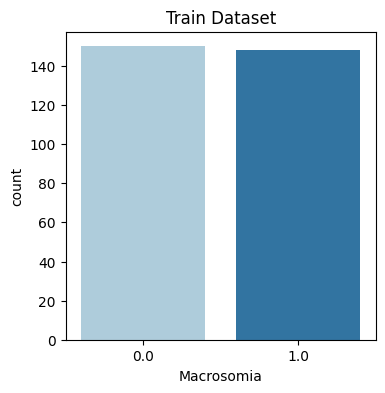

In [23]:
plot_counts(y_train, 'Train Dataset')

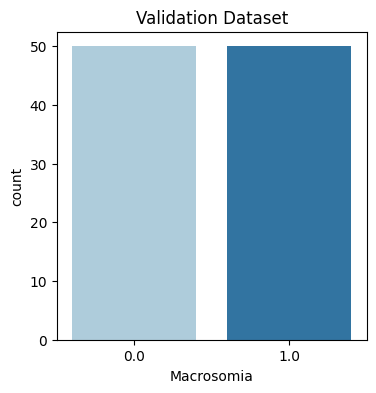

In [24]:
plot_counts(y_valid, 'Validation Dataset')

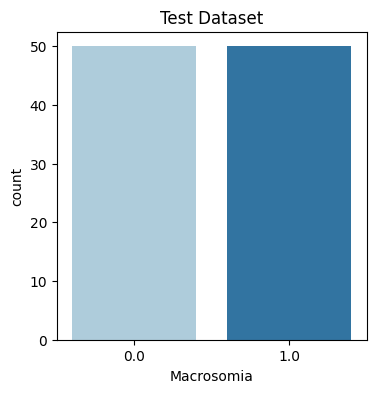

In [25]:
plot_counts(y_test, 'Test Dataset')

# Model Building

## Experiment 1:

### Imputation method: fancyimpute (FI)
### Class imbalance: No (No CI)
### Feature selection: No (No FS)
### Optimization: Grid search (GS)

In [26]:
#fitting model to train set
clf_xgb = xgb.XGBClassifier(objective='binary:logistic', seed=42)
clf_xgb.fit(X_train,
           y_train,
           verbose=True,
           early_stopping_rounds=10,
           eval_metric=['aucpr', 'error'],
           eval_set=[(X_train, y_train), (X_valid, y_valid)])

[0]	validation_0-aucpr:0.86549	validation_0-error:0.18792	validation_1-aucpr:0.66239	validation_1-error:0.43000
[1]	validation_0-aucpr:0.90237	validation_0-error:0.15101	validation_1-aucpr:0.67750	validation_1-error:0.38000
[2]	validation_0-aucpr:0.95392	validation_0-error:0.10738	validation_1-aucpr:0.70773	validation_1-error:0.38000
[3]	validation_0-aucpr:0.96493	validation_0-error:0.10403	validation_1-aucpr:0.72235	validation_1-error:0.35000
[4]	validation_0-aucpr:0.97204	validation_0-error:0.10067	validation_1-aucpr:0.72763	validation_1-error:0.36000
[5]	validation_0-aucpr:0.98051	validation_0-error:0.07718	validation_1-aucpr:0.73982	validation_1-error:0.34000
[6]	validation_0-aucpr:0.98486	validation_0-error:0.06040	validation_1-aucpr:0.72607	validation_1-error:0.37000
[7]	validation_0-aucpr:0.99103	validation_0-error:0.05034	validation_1-aucpr:0.74460	validation_1-error:0.38000
[8]	validation_0-aucpr:0.99098	validation_0-error:0.04362	validation_1-aucpr:0.73438	validation_1-error:

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=42,
              reg_alpha=0, reg_lambda=1, ...)

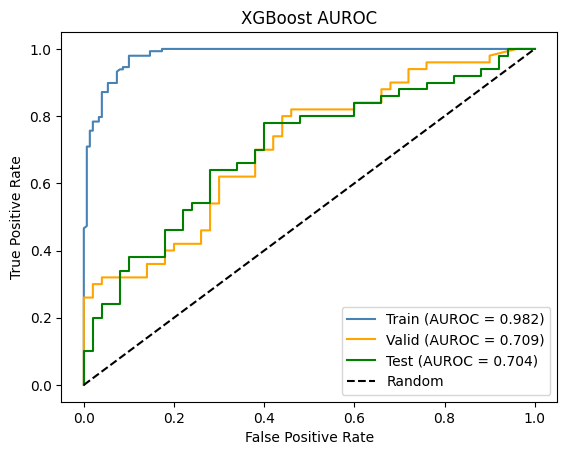

In [27]:
#plotting AUROC curves with AUROC scores for train, valid, and test sets

fig, ax = plt.subplots()

y_pred = clf_xgb.predict_proba(X_train)
fpr, tpr, thresholds = roc_curve(y_train, y_pred[:, [1]])
auroc = roc_auc_score(y_train, y_pred[:, [1]])
ax.plot(fpr, tpr, color='steelblue', label=f'Train (AUROC = {round(auroc, 3)})')

y_pred = clf_xgb.predict_proba(X_valid)
fpr, tpr, thresholds = roc_curve(y_valid, y_pred[:, [1]])
auroc = roc_auc_score(y_valid, y_pred[:, [1]])
ax.plot(fpr, tpr, color='orange', label=f'Valid (AUROC = {round(auroc, 3)})')

y_pred = clf_xgb.predict_proba(X_test)
fpr, tpr, thresholds = roc_curve(y_test, y_pred[:, [1]])
auroc = roc_auc_score(y_test, y_pred[:, [1]])
ax.plot(fpr, tpr, color='green', label=f'Test (AUROC = {round(auroc, 3)})')
ax.plot([0, 1], [0, 1], color='black', linestyle='--', label='Random')

ax.legend()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('XGBoost AUROC')
plt.show()

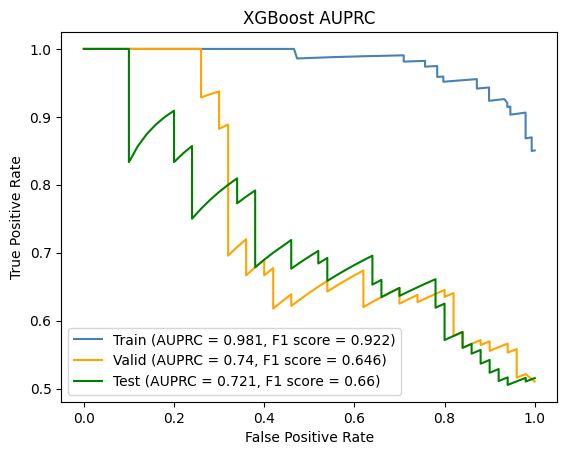

In [28]:
#plotting AUPRC curves with AUPRC and F1 scores for train, valid, and test sets

fig, ax = plt.subplots()

y_pred = clf_xgb.predict_proba(X_train)
precision, recall, thresholds = precision_recall_curve(y_train, y_pred[:, [1]])
auprc, f1 = auc(recall, precision), f1_score(y_train, np.argmax(y_pred, axis=1))
ax.plot(recall, precision, color='steelblue', label=f'Train (AUPRC = {round(auprc, 3)}, F1 score = {round(f1, 3)})')

y_pred = clf_xgb.predict_proba(X_valid)
precision, recall, thresholds = precision_recall_curve(y_valid, y_pred[:, [1]])
auprc, f1 = auc(recall, precision), f1_score(y_valid, np.argmax(y_pred, axis=1))
ax.plot(recall, precision, color='orange', label=f'Valid (AUPRC = {round(auprc, 3)}, F1 score = {round(f1, 3)})')

y_pred = clf_xgb.predict_proba(X_test)
precision, recall, thresholds = precision_recall_curve(y_test, y_pred[:, [1]])
auprc, f1 = auc(recall, precision), f1_score(y_test, np.argmax(y_pred, axis=1))
ax.plot(recall, precision, color='green', label=f'Test (AUPRC = {round(auprc, 3)}, F1 score = {round(f1, 3)})')

ax.legend()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('XGBoost AUPRC')
plt.show()

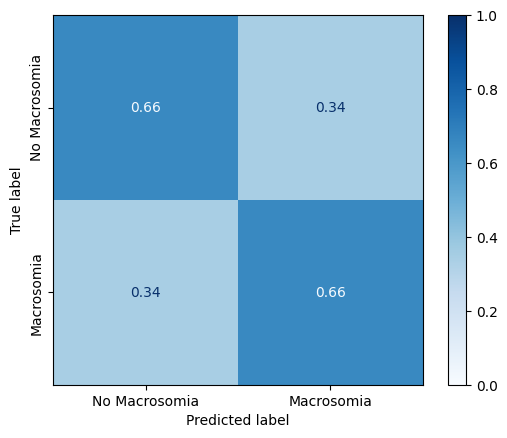

In [29]:
#plotting confusion matrix
predictions = clf_xgb.predict(X_test)
cm = confusion_matrix(y_test, predictions, labels=clf_xgb.classes_)
disp = ConfusionMatrixDisplay.from_estimator(
        clf_xgb,
        X_test,
        y_test,
        display_labels=['No Macrosomia', 'Macrosomia'],
        cmap='Blues',
        normalize='true',
    )
disp.ax_.get_images()[0].set_clim(0, 1) #setting range from 0 to 1
disp.ax_.set_yticklabels(['No Macrosomia', 'Macrosomia'] , rotation=90, va="center") #rotating and centering y labels
plt.show()

In [30]:
# #optimizating using Grid Search

# #ROUND 1

# param_grid = {
#     'max_depth': [3, 4, 5],
#     'learning_rate': [0.01, 0.05, 0.1],
#     'gamma': [0, 0.5, 1],
#     'reg_lambda': [0, 5, 10], 
#     'n_estimators': [50, 70, 90],
#     'min_child_weight': [5, 6, 7]
# }

In [35]:
# #ROUND 2

# param_grid = {
#     'max_depth': [4],
#     'learning_rate': [0.1, 0.2, 0.3],
#     'gamma': [1, 3, 5],
#     'reg_lambda': [10, 11, 12],
#     'n_estimators': [30, 40, 50],
#     'min_child_weight': [7, 8, 9]
# }

In [39]:
# #ROUND 3

# param_grid = {
#     'max_depth': [4],
#     'learning_rate': [0.3, 0.4, 0.5],
#     'gamma': [3],
#     'reg_lambda': [12, 13, 14],
#     'n_estimators': [10, 20, 30],
#     'min_child_weight': [8]
# }

In [42]:
# #ROUND 4

# param_grid = {
#     'max_depth': [4],
#     'learning_rate': [0.3],
#     'gamma': [3],
#     'reg_lambda': [14, 15, 16],
#     'n_estimators': [30],
#     'min_child_weight': [8]
# }

In [45]:
#ROUND 5

param_grid = {
    'max_depth': [4],
    'learning_rate': [0.3],
    'gamma': [3],
    'reg_lambda': [16, 17, 18],
    'n_estimators': [30],
    'min_child_weight': [8]
}

In [46]:
#grid searching for best hyperparameters
optimal_params = GridSearchCV(
    estimator=xgb.XGBClassifier(objective='binary:logistic',
                                seed=42,
                                subsample=0.9,
                                colsample_bytree=0.5,
                               scale_pos_weight = 1),
    param_grid=param_grid,
    scoring='roc_auc',
    verbose=2,
    n_jobs = 10,
    cv = 5
)

In [47]:
#printing optimal parameters to readjust for actual training
optimal_params.fit(X_train, 
                  y_train,
                  early_stopping_rounds=10,
                  eval_metric='auc',
                  eval_set=[(X_valid, y_valid)],
                  verbose=True)
print(optimal_params.best_params_)

Fitting 5 folds for each of 3 candidates, totalling 15 fits
[0]	validation_0-auc:0.68180
[1]	validation_0-auc:0.69300
[2]	validation_0-auc:0.68180
[3]	validation_0-auc:0.69680
[4]	validation_0-auc:0.71720
[5]	validation_0-auc:0.70820
[6]	validation_0-auc:0.70100
[7]	validation_0-auc:0.70500
[8]	validation_0-auc:0.73080
[9]	validation_0-auc:0.74360
[10]	validation_0-auc:0.73480
[11]	validation_0-auc:0.73480
[12]	validation_0-auc:0.72960
[13]	validation_0-auc:0.74320
[14]	validation_0-auc:0.74540
[15]	validation_0-auc:0.73860
[16]	validation_0-auc:0.73860
[17]	validation_0-auc:0.73860
[18]	validation_0-auc:0.73860
[19]	validation_0-auc:0.73860
[20]	validation_0-auc:0.73380
[21]	validation_0-auc:0.73380
[22]	validation_0-auc:0.73380
[23]	validation_0-auc:0.73380
[24]	validation_0-auc:0.73380
{'gamma': 3, 'learning_rate': 0.3, 'max_depth': 4, 'min_child_weight': 8, 'n_estimators': 30, 'reg_lambda': 16}


In [48]:
#fitting model to tuned hyperparameters
clf_xgb = xgb.XGBClassifier(objective='binary:logistic', 
                            seed=42,
                            gamma=3,
                            learning_rate=0.3,
                            max_depth=4,
                            min_child_weight = 8,
                            n_estimators = 30,
                            reg_lambda=16,
                            scale_pos_weight=1, #scale_pos_weight kept "1" because classes are balanced
                            subsample=0.9,
                            colsample_bytree=0.5)

clf_xgb.fit(X_train,
           y_train,
           verbose=True,
           early_stopping_rounds=10,
           eval_metric='auc',
           eval_set=[(X_train, y_train), (X_valid, y_valid), (X_test, y_test)])

[0]	validation_0-auc:0.63514	validation_1-auc:0.68180	validation_2-auc:0.65160
[1]	validation_0-auc:0.71824	validation_1-auc:0.69300	validation_2-auc:0.73860
[2]	validation_0-auc:0.72520	validation_1-auc:0.68180	validation_2-auc:0.74620
[3]	validation_0-auc:0.73354	validation_1-auc:0.69680	validation_2-auc:0.74800
[4]	validation_0-auc:0.74957	validation_1-auc:0.71720	validation_2-auc:0.75800
[5]	validation_0-auc:0.75291	validation_1-auc:0.70820	validation_2-auc:0.76960
[6]	validation_0-auc:0.75536	validation_1-auc:0.70100	validation_2-auc:0.77240
[7]	validation_0-auc:0.75306	validation_1-auc:0.70500	validation_2-auc:0.77240
[8]	validation_0-auc:0.75550	validation_1-auc:0.73080	validation_2-auc:0.77500
[9]	validation_0-auc:0.75919	validation_1-auc:0.74360	validation_2-auc:0.77540
[10]	validation_0-auc:0.75595	validation_1-auc:0.73480	validation_2-auc:0.77220
[11]	validation_0-auc:0.75595	validation_1-auc:0.73480	validation_2-auc:0.77220
[12]	validation_0-auc:0.75446	validation_1-auc:0.7

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.5,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=3, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.3, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=4, max_leaves=0, min_child_weight=8,
              missing=nan, monotone_constraints='()', n_estimators=30, n_jobs=0,
              num_parallel_tree=1, predictor='auto', random_state=42,
              reg_alpha=0, reg_lambda=16, ...)

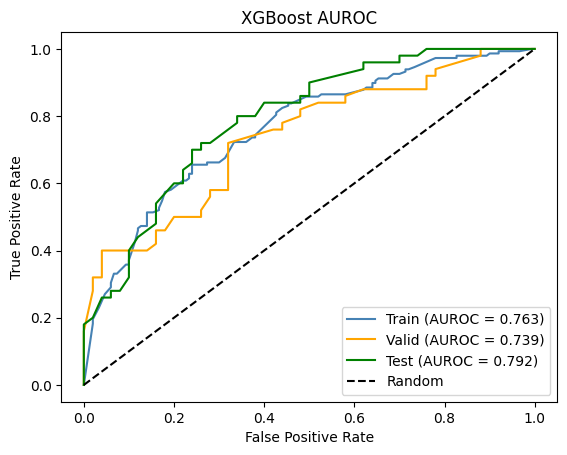

In [49]:
#plotting AUROC curves with AUROC scores for train, valid, and test sets

fig, ax = plt.subplots()

y_pred = clf_xgb.predict_proba(X_train)
fpr, tpr, thresholds = roc_curve(y_train, y_pred[:, [1]])
auroc = roc_auc_score(y_train, y_pred[:, [1]])
ax.plot(fpr, tpr, color='steelblue', label=f'Train (AUROC = {round(auroc, 3)})')

y_pred = clf_xgb.predict_proba(X_valid)
fpr, tpr, thresholds = roc_curve(y_valid, y_pred[:, [1]])
auroc = roc_auc_score(y_valid, y_pred[:, [1]])
ax.plot(fpr, tpr, color='orange', label=f'Valid (AUROC = {round(auroc, 3)})')

y_pred = clf_xgb.predict_proba(X_test)
fpr, tpr, thresholds = roc_curve(y_test, y_pred[:, [1]])
auroc = roc_auc_score(y_test, y_pred[:, [1]])
ax.plot(fpr, tpr, color='green', label=f'Test (AUROC = {round(auroc, 3)})')
ax.plot([0, 1], [0, 1], color='black', linestyle='--', label='Random')

ax.legend()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('XGBoost AUROC')
plt.show()

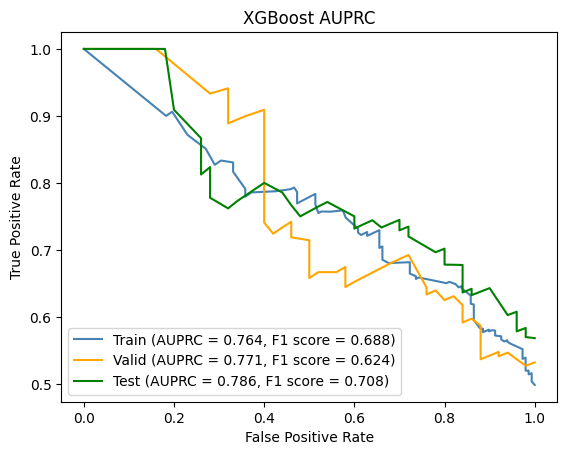

In [50]:
#plotting AUPRC curves with AUPRC and F1 scores for train, valid, and test sets

fig, ax = plt.subplots()

y_pred = clf_xgb.predict_proba(X_train)
precision, recall, thresholds = precision_recall_curve(y_train, y_pred[:, [1]])
auprc, f1 = auc(recall, precision), f1_score(y_train, np.argmax(y_pred, axis=1))
ax.plot(recall, precision, color='steelblue', label=f'Train (AUPRC = {round(auprc, 3)}, F1 score = {round(f1, 3)})')

y_pred = clf_xgb.predict_proba(X_valid)
precision, recall, thresholds = precision_recall_curve(y_valid, y_pred[:, [1]])
auprc, f1 = auc(recall, precision), f1_score(y_valid, np.argmax(y_pred, axis=1))
ax.plot(recall, precision, color='orange', label=f'Valid (AUPRC = {round(auprc, 3)}, F1 score = {round(f1, 3)})')

y_pred = clf_xgb.predict_proba(X_test)
precision, recall, thresholds = precision_recall_curve(y_test, y_pred[:, [1]])
auprc, f1 = auc(recall, precision), f1_score(y_test, np.argmax(y_pred, axis=1))
ax.plot(recall, precision, color='green', label=f'Test (AUPRC = {round(auprc, 3)}, F1 score = {round(f1, 3)})')

ax.legend()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('XGBoost AUPRC')
plt.show()

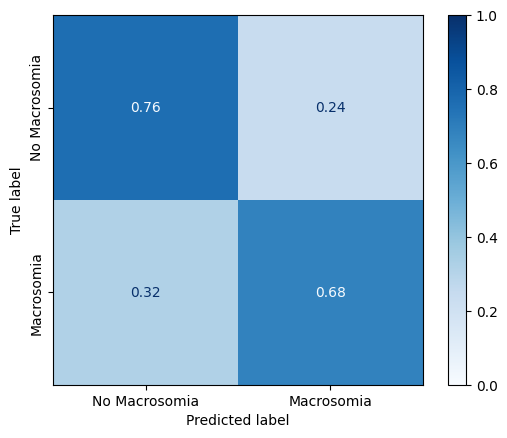

In [51]:
#plotting confusion matrix
predictions = clf_xgb.predict(X_test)
cm = confusion_matrix(y_test, predictions, labels=clf_xgb.classes_)
disp = ConfusionMatrixDisplay.from_estimator(
        clf_xgb,
        X_test,
        y_test,
        display_labels=['No Macrosomia', 'Macrosomia'],
        cmap='Blues',
        normalize='true',
    )
disp.ax_.get_images()[0].set_clim(0, 1) #setting range from 0 to 1
disp.ax_.set_yticklabels(['No Macrosomia', 'Macrosomia'] , rotation=90, va="center") #rotating and centering y labels
plt.show()

weight:  {'AGE_AT_DELIVERY': 3.0, 'Para': 2.0, 'Term': 3.0, 'RACE_White': 1.0, 'R_BMI': 8.0, 'GA_IN_DAYS': 4.0}
gain:  {'AGE_AT_DELIVERY': 3.309995412826538, 'Para': 5.29371452331543, 'Term': 4.642707347869873, 'RACE_White': 2.6754143238067627, 'R_BMI': 7.658562183380127, 'GA_IN_DAYS': 2.9313578605651855}
cover:  {'AGE_AT_DELIVERY': 47.54620361328125, 'Para': 66.15272521972656, 'Term': 55.06503677368164, 'RACE_White': 63.14032745361328, 'R_BMI': 65.25969696044922, 'GA_IN_DAYS': 54.946956634521484}
total_gain:  {'AGE_AT_DELIVERY': 9.929986000061035, 'Para': 10.58742904663086, 'Term': 13.928122520446777, 'RACE_White': 2.6754143238067627, 'R_BMI': 61.268497467041016, 'GA_IN_DAYS': 11.725431442260742}
total_cover:  {'AGE_AT_DELIVERY': 142.63861083984375, 'Para': 132.30545043945312, 'Term': 165.1951141357422, 'RACE_White': 63.14032745361328, 'R_BMI': 522.0775756835938, 'GA_IN_DAYS': 219.78782653808594}


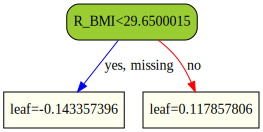

In [52]:
#plotting tree
bst = clf_xgb.get_booster()
for importance_type in ('weight', 'gain', 'cover', 'total_gain', 'total_cover'):
    print('%s: ' % importance_type, bst.get_score(importance_type=importance_type))

node_params = {'shape': 'box',
               'style': 'filled, rounded',
               'fillcolor': '#9ACD32'     
                }  

leaf_params = {'shape': 'box',
               'style': 'filled',
               'fillcolor': '#FFFFF0'     
                }  

xgb.to_graphviz(clf_xgb, num_trees=1
                , size='10,10',
               condition_node_params=node_params,
               leaf_node_params=leaf_params)

#add .render() at the end to save as pdf

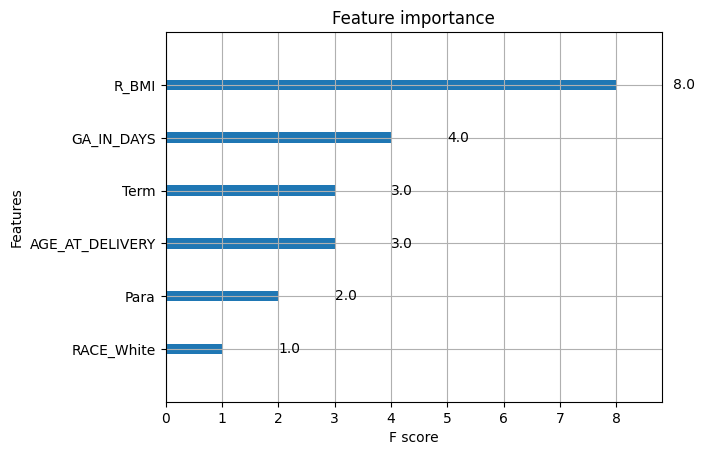

In [53]:
#plotting overall feature importance
plot_importance(clf_xgb)
plt.show()

In [54]:
#plotting individual feature importance
explainer = shap.Explainer(clf_xgb)
shap_values = explainer(X_test)

# visualize the first prediction's explanation
shap.initjs()
shap.plots.force(shap_values[0])

## Experiment 2:

### Imputation method: fancyimpute (FI)
### Class imbalance: No (No CI)
### Feature selection: No (No FS)
### Optimization: Bayesian (Bay.)

In [103]:
#Converting the dataframe into XGBoost’s Dmatrix object
dtrain = xgb.DMatrix(X_train, label=y_train)

#Bayesian Optimization function for xgboost
#specify the parameters you want to tune as keyword arguments
def bo_tune_xgb(max_depth, gamma, n_estimators, learning_rate, reg_lambda, min_child_weight):
    params = {'max_depth': int(max_depth),
              'learning_rate':learning_rate,
              'gamma': gamma,
              'reg_lambda': reg_lambda,
              'n_estimators': int(n_estimators),
              'min_child_weight': min_child_weight,
              'subsample': 0.9,
              'eta': 0.1,
              
              'eval_metric': 'rmse'}
    #Cross validating with the specified parameters in 5 folds and 70 iterations
    cv_result = xgb.cv(params, dtrain, num_boost_round=70, nfold=5)
    #Return the negative RMSE
    return -1.0 * cv_result['test-rmse-mean'].iloc[-1]

#Invoking the Bayesian Optimizer with the specified parameters to tune
xgb_bo = BayesianOptimization(bo_tune_xgb, {'max_depth': (3, 10),
                                            'learning_rate': (0, 1),
                                            'gamma': (0, 5),
                                            'reg_lambda': (3, 20), 
                                            'n_estimators': (50, 350),
                                            'min_child_weight': (1, 10)
                                            }, random_state = 42)

#performing Bayesian optimization for 5 iterations with 8 steps of random exploration with an acquisition function of expected improvement
xgb_bo.maximize(n_iter=5, init_points=8, acq='ei')

|   iter    |  target   |   gamma   | learni... | max_depth | min_ch... | n_esti... | reg_la... |
-------------------------------------------------------------------------------------------------
[02:09:32] WARNING: ../src/learner.cc:627: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[02:09:32] WARNING: ../src/learner.cc:627: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[02:09:32] WARNING: ../src/learner.cc:627: 
Parameters: { "n_estimators" } mig

|  5        | -0.4792   |  2.28     |  0.7852   |  4.398    |  5.628    |  227.7    |  3.79     |
[02:09:43] WARNING: ../src/learner.cc:627: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[02:09:43] WARNING: ../src/learner.cc:627: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[02:09:43] WARNING: ../src/learner.cc:627: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bind

|  10       | -0.5009   |  0.621    |  0.7127   |  8.185    |  2.408    |  240.1    |  18.04    |
[02:09:54] WARNING: ../src/learner.cc:627: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[02:09:54] WARNING: ../src/learner.cc:627: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[02:09:54] WARNING: ../src/learner.cc:627: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bind

In [104]:
from sklearn.metrics import classification_report, confusion_matrix

#Extracting the best parameters
params = xgb_bo.max['params']
print(params)

#Converting the max_depth and n_estimator values from float to int
params['max_depth']= int(params['max_depth'])
params['n_estimators']= int(params['n_estimators'])

#Initialize an XGBClassifier with the tuned parameters and fit the training data
from xgboost import XGBClassifier
bay_classifier = XGBClassifier(**params).fit(X_train, y_train)

#predicting for training set
train_p2 = bay_classifier.predict(X_valid)

#Looking at the classification report
print(classification_report(train_p2, y_valid))

{'gamma': 1.5230688458668533, 'learning_rate': 0.09767211400638387, 'max_depth': 7.789631185585098, 'min_child_weight': 4.961372443656412, 'n_estimators': 86.61147045343364, 'reg_lambda': 11.418007471891594}
              precision    recall  f1-score   support

           0       0.72      0.61      0.66        59
           1       0.54      0.66      0.59        41

    accuracy                           0.63       100
   macro avg       0.63      0.63      0.63       100
weighted avg       0.65      0.63      0.63       100



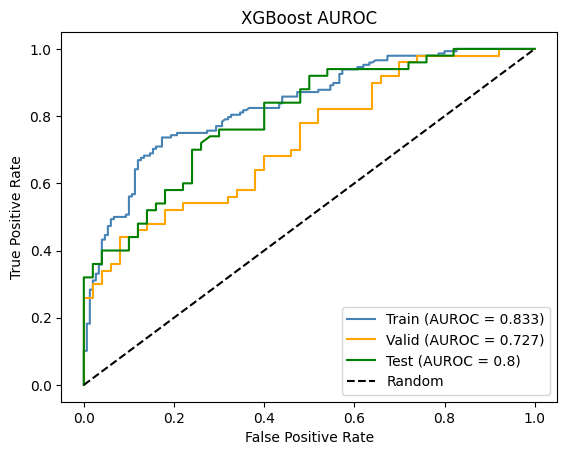

In [105]:
#plotting AUROC curves with AUROC scores for train, valid, and test sets

fig, ax = plt.subplots()

y_pred = bay_classifier.predict_proba(X_train)
fpr, tpr, thresholds = roc_curve(y_train, y_pred[:, [1]])
auroc = roc_auc_score(y_train, y_pred[:, [1]])
ax.plot(fpr, tpr, color='steelblue', label=f'Train (AUROC = {round(auroc, 3)})')

y_pred = bay_classifier.predict_proba(X_valid)
fpr, tpr, thresholds = roc_curve(y_valid, y_pred[:, [1]])
auroc = roc_auc_score(y_valid, y_pred[:, [1]])
ax.plot(fpr, tpr, color='orange', label=f'Valid (AUROC = {round(auroc, 3)})')

y_pred = bay_classifier.predict_proba(X_test)
fpr, tpr, thresholds = roc_curve(y_test, y_pred[:, [1]])
auroc = roc_auc_score(y_test, y_pred[:, [1]])
ax.plot(fpr, tpr, color='green', label=f'Test (AUROC = {round(auroc, 3)})')
ax.plot([0, 1], [0, 1], color='black', linestyle='--', label='Random')

ax.legend()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('XGBoost AUROC')
plt.show()

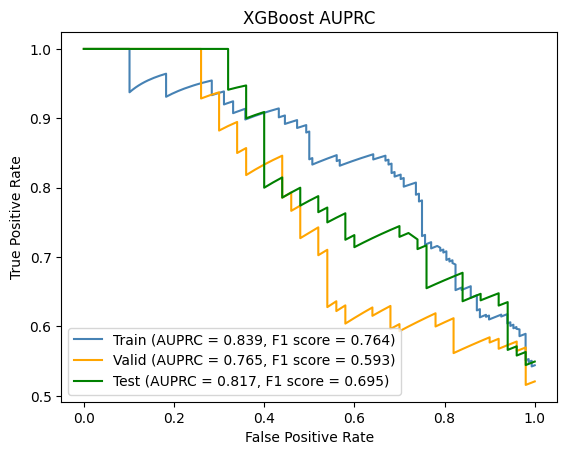

In [106]:
#plotting AUPRC curves with AUPRC and F1 scores for train, valid, and test sets

fig, ax = plt.subplots()
y_pred = bay_classifier.predict_proba(X_train)
precision, recall, thresholds = precision_recall_curve(y_train, y_pred[:, [1]])
auprc, f1 = auc(recall, precision), f1_score(y_train, np.argmax(y_pred, axis=1))
ax.plot(recall, precision, color='steelblue', label=f'Train (AUPRC = {round(auprc, 3)}, F1 score = {round(f1, 3)})')

y_pred = bay_classifier.predict_proba(X_valid)
precision, recall, thresholds = precision_recall_curve(y_valid, y_pred[:, [1]])
auprc, f1 = auc(recall, precision), f1_score(y_valid, np.argmax(y_pred, axis=1))
ax.plot(recall, precision, color='orange', label=f'Valid (AUPRC = {round(auprc, 3)}, F1 score = {round(f1, 3)})')

y_pred = bay_classifier.predict_proba(X_test)
precision, recall, thresholds = precision_recall_curve(y_test, y_pred[:, [1]])
auprc, f1 = auc(recall, precision), f1_score(y_test, np.argmax(y_pred, axis=1))
ax.plot(recall, precision, color='green', label=f'Test (AUPRC = {round(auprc, 3)}, F1 score = {round(f1, 3)})')

ax.legend()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('XGBoost AUPRC')
plt.show()

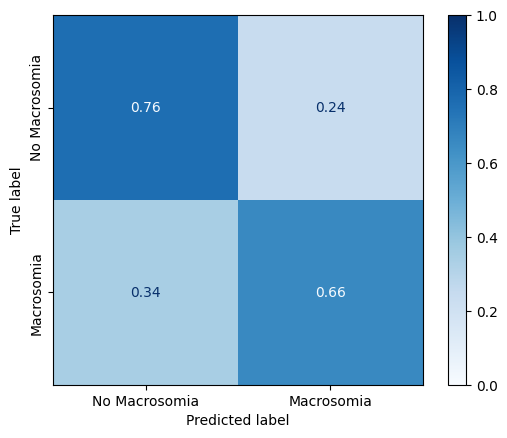

In [107]:
#plotting confusion matrix
predictions = bay_classifier.predict(X_test)
cm = confusion_matrix(y_test, predictions, labels=bay_classifier.classes_)
disp = ConfusionMatrixDisplay.from_estimator(
        bay_classifier,
        X_test,
        y_test,
        display_labels=['No Macrosomia', 'Macrosomia'],
        cmap='Blues',
        normalize='true',
    )
disp.ax_.get_images()[0].set_clim(0, 1) #setting range from 0 to 1
disp.ax_.set_yticklabels(['No Macrosomia', 'Macrosomia'] , rotation=90, va="center") #rotating and centering y labels
plt.show()

weight:  {'AGE_AT_DELIVERY': 19.0, 'Gravida': 3.0, 'Para': 7.0, 'Term': 18.0, 'Living_at_Delivery_Ct': 7.0, 'RACE_White': 6.0, 'R_BMI': 38.0, 'GA_IN_DAYS': 37.0, 'HEMOGLOBIN_THIRD_TRIMESTER': 11.0, 'Baby_Sex': 3.0}
gain:  {'AGE_AT_DELIVERY': 2.0376198291778564, 'Gravida': 2.233649492263794, 'Para': 2.420466184616089, 'Term': 2.6046836376190186, 'Living_at_Delivery_Ct': 2.896749973297119, 'RACE_White': 1.6930042505264282, 'R_BMI': 6.209660530090332, 'GA_IN_DAYS': 2.0628020763397217, 'HEMOGLOBIN_THIRD_TRIMESTER': 2.0931735038757324, 'Baby_Sex': 2.147763967514038}
cover:  {'AGE_AT_DELIVERY': 41.705108642578125, 'Gravida': 38.935848236083984, 'Para': 20.276243209838867, 'Term': 49.16688537597656, 'Living_at_Delivery_Ct': 36.701229095458984, 'RACE_White': 41.46916580200195, 'R_BMI': 63.776309967041016, 'GA_IN_DAYS': 29.467266082763672, 'HEMOGLOBIN_THIRD_TRIMESTER': 33.816715240478516, 'Baby_Sex': 48.41486740112305}
total_gain:  {'AGE_AT_DELIVERY': 38.71477508544922, 'Gravida': 6.70094871520

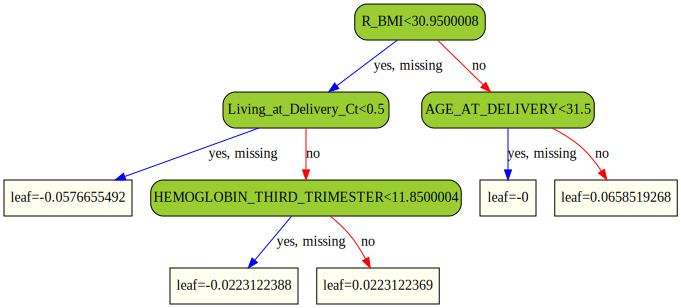

In [108]:
#plotting tree
bst = bay_classifier.get_booster()
for importance_type in ('weight', 'gain', 'cover', 'total_gain', 'total_cover'):
    print('%s: ' % importance_type, bst.get_score(importance_type=importance_type))

node_params = {'shape': 'box',
               'style': 'filled, rounded',
               'fillcolor': '#9ACD32'     
                }  

leaf_params = {'shape': 'box',
               'style': 'filled',
               'fillcolor': '#FFFFF0'     
                }  

xgb.to_graphviz(bay_classifier, num_trees=1, 
                size='10,10',
                condition_node_params=node_params,
                leaf_node_params=leaf_params)

#add .render() at the end to save as pdf

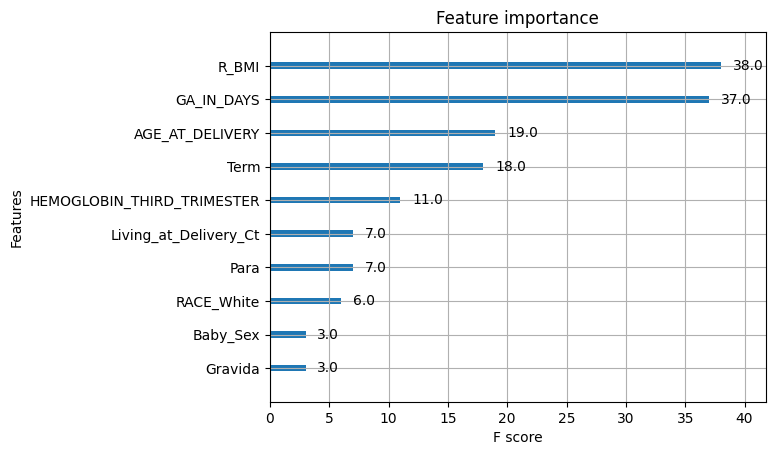

In [109]:
#plotting overall feature importance
plot_importance(bay_classifier)
plt.show()

In [110]:
#plotting individual feature importance
explainer = shap.Explainer(bay_classifier)
shap_values = explainer(X_test)

# visualize the first prediction's explanation
shap.initjs()
shap.plots.force(shap_values[0])

## Experiment 3:

### Imputation method: fancyimpute (FI)
### Class imbalance: No (No CI)
### Feature selection: Yes (FS)
### Optimization: Grid search (GS)

In [111]:
#selecting features

thresholds = sort(clf_xgb.feature_importances_)
for thresh in thresholds:
    # select features using threshold
    selection = SelectFromModel(clf_xgb, threshold=thresh, prefit=True)
    select_X_train = selection.transform(X_train)
    # train model
    selection_model = XGBClassifier()
    selection_model.fit(select_X_train, y_train)
    # eval model
    select_X_test = selection.transform(X_test)
    y_pred = selection_model.predict(select_X_test)
    predictions = [round(value) for value in y_pred]
    accuracy = accuracy_score(y_test, predictions)
    print("Thresh=%.3f, n=%d, Accuracy: %.2f%%" % (thresh, select_X_train.shape[1], accuracy*100.0))

Thresh=0.000, n=33, Accuracy: 61.00%
Thresh=0.000, n=33, Accuracy: 61.00%
Thresh=0.000, n=33, Accuracy: 61.00%
Thresh=0.000, n=33, Accuracy: 61.00%
Thresh=0.000, n=33, Accuracy: 61.00%
Thresh=0.000, n=33, Accuracy: 61.00%
Thresh=0.000, n=33, Accuracy: 61.00%
Thresh=0.000, n=33, Accuracy: 61.00%
Thresh=0.000, n=33, Accuracy: 61.00%
Thresh=0.000, n=33, Accuracy: 61.00%
Thresh=0.000, n=33, Accuracy: 61.00%
Thresh=0.000, n=33, Accuracy: 61.00%
Thresh=0.000, n=33, Accuracy: 61.00%
Thresh=0.000, n=33, Accuracy: 61.00%
Thresh=0.000, n=33, Accuracy: 61.00%
Thresh=0.000, n=33, Accuracy: 61.00%
Thresh=0.000, n=33, Accuracy: 61.00%
Thresh=0.000, n=33, Accuracy: 61.00%
Thresh=0.000, n=33, Accuracy: 61.00%
Thresh=0.000, n=33, Accuracy: 61.00%
Thresh=0.000, n=33, Accuracy: 61.00%
Thresh=0.000, n=33, Accuracy: 61.00%
Thresh=0.000, n=33, Accuracy: 61.00%
Thresh=0.000, n=33, Accuracy: 61.00%
Thresh=0.000, n=33, Accuracy: 61.00%
Thresh=0.000, n=33, Accuracy: 61.00%
Thresh=0.000, n=33, Accuracy: 61.00%
T

In [112]:
#selecting and fitting model to threshold producing best accuracy

selection = SelectFromModel(clf_xgb, threshold=0.055, prefit=True)
select_X_train = selection.transform(X_train)

# train model
selection_model = XGBClassifier()
selection_model.fit(select_X_train, y_train)

# eval model
select_X_valid = selection.transform(X_valid)
select_X_test = selection.transform(X_test)

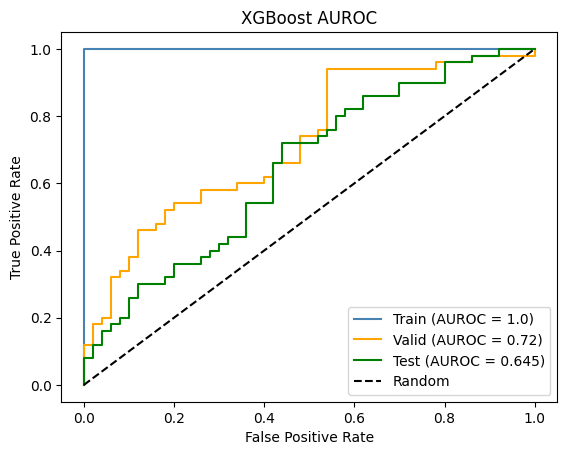

In [113]:
#plotting AUROC curves with AUROC scores for train, valid, and test sets

fig, ax = plt.subplots()

y_pred = selection_model.predict_proba(select_X_train)
fpr, tpr, thresholds = roc_curve(y_train, y_pred[:, [1]])
auroc = roc_auc_score(y_train, y_pred[:, [1]])
ax.plot(fpr, tpr, color='steelblue', label=f'Train (AUROC = {round(auroc, 3)})')

y_pred = selection_model.predict_proba(select_X_valid)
fpr, tpr, thresholds = roc_curve(y_valid, y_pred[:, [1]])
auroc = roc_auc_score(y_valid, y_pred[:, [1]])
ax.plot(fpr, tpr, color='orange', label=f'Valid (AUROC = {round(auroc, 3)})')

y_pred = selection_model.predict_proba(select_X_test)
fpr, tpr, thresholds = roc_curve(y_test, y_pred[:, [1]])
auroc = roc_auc_score(y_test, y_pred[:, [1]])
ax.plot(fpr, tpr, color='green', label=f'Test (AUROC = {round(auroc, 3)})')
ax.plot([0, 1], [0, 1], color='black', linestyle='--', label='Random')

ax.legend()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('XGBoost AUROC')
plt.show()

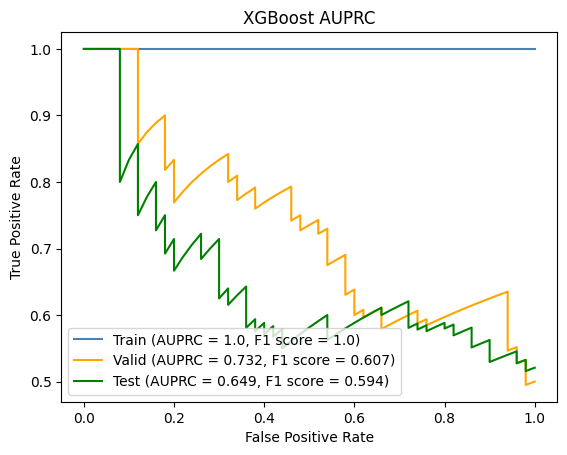

In [114]:
#plotting AUPRC curves with AUPRC and F1 scores for train, valid, and test sets

fig, ax = plt.subplots()

y_pred = selection_model.predict_proba(select_X_train)
precision, recall, thresholds = precision_recall_curve(y_train, y_pred[:, [1]])
auprc, f1 = auc(recall, precision), f1_score(y_train, np.argmax(y_pred, axis=1))
ax.plot(recall, precision, color='steelblue', label=f'Train (AUPRC = {round(auprc, 3)}, F1 score = {round(f1, 3)})')

y_pred = selection_model.predict_proba(select_X_valid)
precision, recall, thresholds = precision_recall_curve(y_valid, y_pred[:, [1]])
auprc, f1 = auc(recall, precision), f1_score(y_valid, np.argmax(y_pred, axis=1))
ax.plot(recall, precision, color='orange', label=f'Valid (AUPRC = {round(auprc, 3)}, F1 score = {round(f1, 3)})')

y_pred = selection_model.predict_proba(select_X_test)
precision, recall, thresholds = precision_recall_curve(y_test, y_pred[:, [1]])
auprc, f1 = auc(recall, precision), f1_score(y_test, np.argmax(y_pred, axis=1))
ax.plot(recall, precision, color='green', label=f'Test (AUPRC = {round(auprc, 3)}, F1 score = {round(f1, 3)})')

ax.legend()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('XGBoost AUPRC')
plt.show()

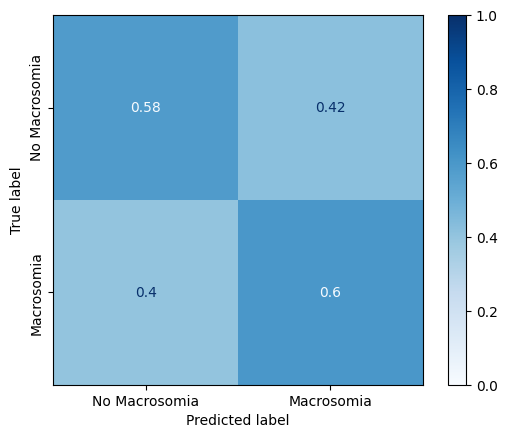

In [115]:
#plotting confusion matrix
predictions = selection_model.predict(select_X_test)
cm = confusion_matrix(y_test, predictions, labels=selection_model.classes_)
disp = ConfusionMatrixDisplay.from_estimator(
        selection_model,
        select_X_test,
        y_test,
        display_labels=['No Macrosomia', 'Macrosomia'],
        cmap='Blues',
        normalize='true',
    )
disp.ax_.get_images()[0].set_clim(0, 1) #setting range from 0 to 1
disp.ax_.set_yticklabels(['No Macrosomia', 'Macrosomia'] , rotation=90, va="center") #rotating and centering y labels
plt.show()

In [116]:
# #optimizating using Grid Search

# #ROUND 1

# param_grid = {
#     'max_depth': [3, 4, 5],
#     'learning_rate': [0.01, 0.05, 0.1],
#     'gamma': [0, 0.5, 1],
#     'reg_lambda': [0, 5, 10], 
#     'n_estimators': [50, 70, 90],
#     'min_child_weight': [5, 6, 7]
# }

In [121]:
# #ROUND 2

# param_grid = {
#     'max_depth': [1, 2, 3],
#     'learning_rate': [0.1, 0.2, 0.3],
#     'gamma': [1, 2, 3],
#     'reg_lambda': [10, 11, 12],
#     'n_estimators': [30, 40, 50],
#     'min_child_weight': [3, 4, 5]
# }

In [125]:
#ROUND 3

param_grid = {
    'max_depth': [2],
    'learning_rate': [0.2],
    'gamma': [1],
    'reg_lambda': [10],
    'n_estimators': [40],
    'min_child_weight': [5, 6, 7]
}

In [126]:
#grid searching for best hyperparameters
optimal_params = GridSearchCV(
    estimator=xgb.XGBClassifier(objective='binary:logistic',
                                seed=42,
                                subsample=0.9,
                                colsample_bytree=0.5),
    param_grid=param_grid,
    scoring='roc_auc',
    verbose=2,
    n_jobs = 10,
    cv = 5
)

In [127]:
#printing optimal parameters to readjust for actual training
optimal_params.fit(select_X_train, 
                  y_train,
                  early_stopping_rounds=10,
                  eval_metric='auc',
                  eval_set=[(select_X_valid, y_valid)],
                  verbose=False)
print(optimal_params.best_params_)

Fitting 5 folds for each of 3 candidates, totalling 15 fits
{'gamma': 1, 'learning_rate': 0.2, 'max_depth': 2, 'min_child_weight': 5, 'n_estimators': 40, 'reg_lambda': 10}


In [128]:
#fitting model to tuned hyperparameters
selection_model = xgb.XGBClassifier(objective='binary:logistic', 
                            seed=42,
                            gamma=1,
                            learning_rate=0.2,
                            max_depth=2,
                            min_child_weight = 5,
                            n_estimators = 40,
                            reg_lambda=10,
                            scale_pos_weight=1, #scale_pos_weight kept "1" because classes are balanced
                            subsample=0.9,
                            colsample_bytree=0.5)

selection_model.fit(select_X_train,
           y_train,
           verbose=True,
           early_stopping_rounds=10,
           eval_metric='auc',
           eval_set=[(select_X_train, y_train), (select_X_valid, y_valid), (select_X_test, y_test)])

[0]	validation_0-auc:0.65302	validation_1-auc:0.66940	validation_2-auc:0.64920
[1]	validation_0-auc:0.68036	validation_1-auc:0.64400	validation_2-auc:0.70740
[2]	validation_0-auc:0.68347	validation_1-auc:0.64600	validation_2-auc:0.70640
[3]	validation_0-auc:0.68842	validation_1-auc:0.62140	validation_2-auc:0.71620
[4]	validation_0-auc:0.74664	validation_1-auc:0.67120	validation_2-auc:0.77360
[5]	validation_0-auc:0.76203	validation_1-auc:0.69220	validation_2-auc:0.77740
[6]	validation_0-auc:0.77545	validation_1-auc:0.71160	validation_2-auc:0.78840
[7]	validation_0-auc:0.77694	validation_1-auc:0.71320	validation_2-auc:0.78840
[8]	validation_0-auc:0.77642	validation_1-auc:0.71560	validation_2-auc:0.79660
[9]	validation_0-auc:0.77590	validation_1-auc:0.71780	validation_2-auc:0.79960
[10]	validation_0-auc:0.78191	validation_1-auc:0.71640	validation_2-auc:0.80120
[11]	validation_0-auc:0.78149	validation_1-auc:0.71120	validation_2-auc:0.79840
[12]	validation_0-auc:0.78266	validation_1-auc:0.7

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.5,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=1, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.2, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=2, max_leaves=0, min_child_weight=5,
              missing=nan, monotone_constraints='()', n_estimators=40, n_jobs=0,
              num_parallel_tree=1, predictor='auto', random_state=42,
              reg_alpha=0, reg_lambda=10, ...)

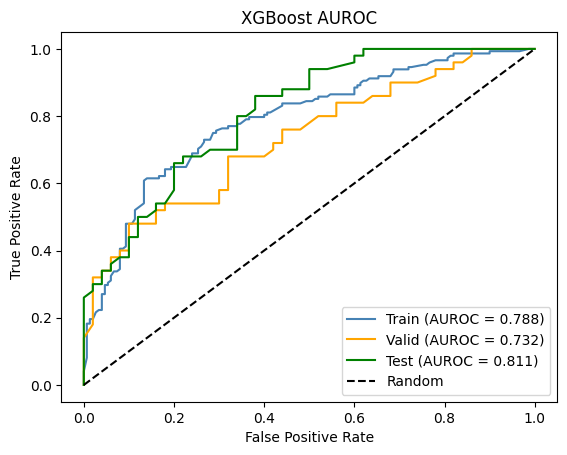

In [129]:
#plotting AUROC curves with AUROC scores for train, valid, and test sets

fig, ax = plt.subplots()

y_pred = selection_model.predict_proba(select_X_train)
fpr, tpr, thresholds = roc_curve(y_train, y_pred[:, [1]])
auroc = roc_auc_score(y_train, y_pred[:, [1]])
ax.plot(fpr, tpr, color='steelblue', label=f'Train (AUROC = {round(auroc, 3)})')

y_pred = selection_model.predict_proba(select_X_valid)
fpr, tpr, thresholds = roc_curve(y_valid, y_pred[:, [1]])
auroc = roc_auc_score(y_valid, y_pred[:, [1]])
ax.plot(fpr, tpr, color='orange', label=f'Valid (AUROC = {round(auroc, 3)})')

y_pred = selection_model.predict_proba(select_X_test)
fpr, tpr, thresholds = roc_curve(y_test, y_pred[:, [1]])
auroc = roc_auc_score(y_test, y_pred[:, [1]])
ax.plot(fpr, tpr, color='green', label=f'Test (AUROC = {round(auroc, 3)})')
ax.plot([0, 1], [0, 1], color='black', linestyle='--', label='Random')

ax.legend()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('XGBoost AUROC')
plt.show()

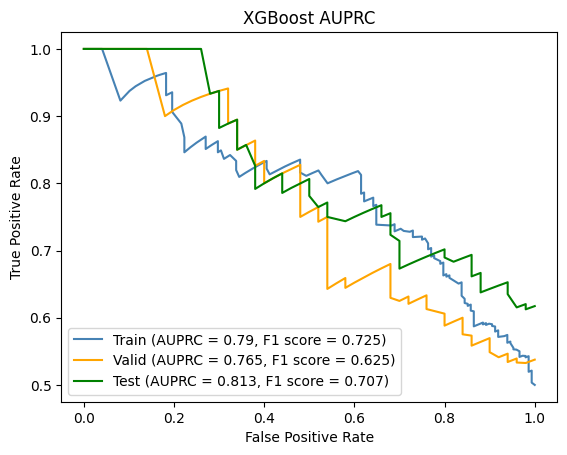

In [130]:
#plotting AUPRC curves with AUPRC and F1 scores for train, valid, and test sets

fig, ax = plt.subplots()

y_pred = selection_model.predict_proba(select_X_train)
precision, recall, thresholds = precision_recall_curve(y_train, y_pred[:, [1]])
auprc, f1 = auc(recall, precision), f1_score(y_train, np.argmax(y_pred, axis=1))
ax.plot(recall, precision, color='steelblue', label=f'Train (AUPRC = {round(auprc, 3)}, F1 score = {round(f1, 3)})')

y_pred = selection_model.predict_proba(select_X_valid)
precision, recall, thresholds = precision_recall_curve(y_valid, y_pred[:, [1]])
auprc, f1 = auc(recall, precision), f1_score(y_valid, np.argmax(y_pred, axis=1))
ax.plot(recall, precision, color='orange', label=f'Valid (AUPRC = {round(auprc, 3)}, F1 score = {round(f1, 3)})')

y_pred = selection_model.predict_proba(select_X_test)
precision, recall, thresholds = precision_recall_curve(y_test, y_pred[:, [1]])
auprc, f1 = auc(recall, precision), f1_score(y_test, np.argmax(y_pred, axis=1))
ax.plot(recall, precision, color='green', label=f'Test (AUPRC = {round(auprc, 3)}, F1 score = {round(f1, 3)})')

ax.legend()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('XGBoost AUPRC')
plt.show()

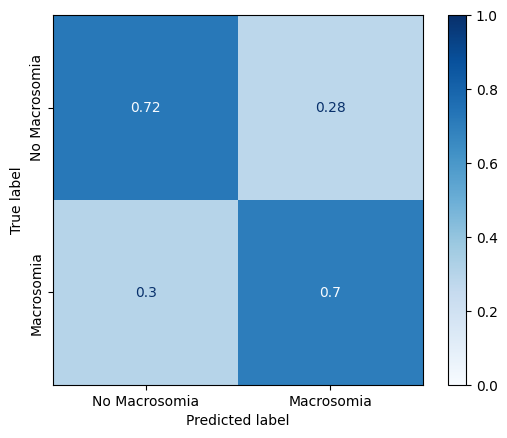

In [131]:
#plotting confusion matrix
predictions = selection_model.predict(select_X_test)
cm = confusion_matrix(y_test, predictions, labels=selection_model.classes_)
disp = ConfusionMatrixDisplay.from_estimator(
        selection_model,
        select_X_test,
        y_test,
        display_labels=['No Macrosomia', 'Macrosomia'],
        cmap='Blues',
        normalize='true',
    )
disp.ax_.get_images()[0].set_clim(0, 1) #setting range from 0 to 1
disp.ax_.set_yticklabels(['No Macrosomia', 'Macrosomia'] , rotation=90, va="center") #rotating and centering y labels
plt.show()

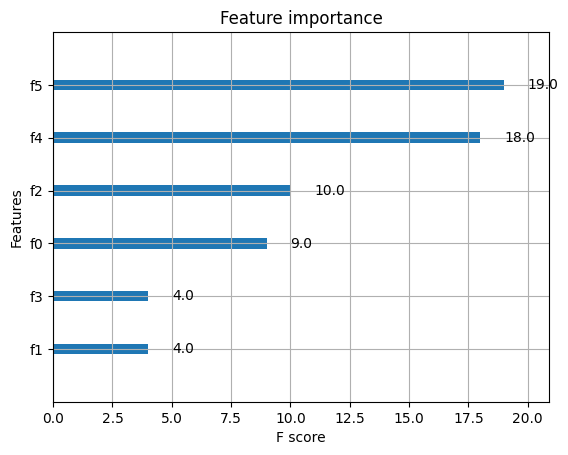

In [132]:
#plotting overall feature importance
plot_importance(selection_model)
plt.show()

In [133]:
#plotting individual feature importance
explainer = shap.Explainer(clf_xgb)
shap_values = explainer(X_test)

# visualize the first prediction's explanation
shap.plots.force(shap_values[1])

## Experiment 4:

### Imputation method: fancyimpute (FI)
### Class imbalance: No (No CI)
### Feature selection: Yes (FS)
### Optimization: Bayesian (Bay.)

In [ ]:
#Converting the dataframe into XGBoost’s Dmatrix object
dtrain = xgb.DMatrix(select_X_train, label=y_train)

#Bayesian Optimization function for xgboost
#specify the parameters you want to tune as keyword arguments
def bo_tune_xgb(max_depth, gamma, n_estimators, learning_rate, reg_lambda, min_child_weight):
    params = {'max_depth': int(max_depth),
              'learning_rate':learning_rate,
              'gamma': gamma,
              'reg_lambda': reg_lambda,
              'n_estimators': int(n_estimators),
              'min_child_weight': min_child_weight,
              'subsample': 0.9,
              'eta': 0.1,
              
              'eval_metric': 'rmse'}
    #Cross validating with the specified parameters in 5 folds and 70 iterations
    cv_result = xgb.cv(params, dtrain, num_boost_round=70, nfold=5)
    #Return the negative RMSE
    return -1.0 * cv_result['test-rmse-mean'].iloc[-1]

#Invoking the Bayesian Optimizer with the specified parameters to tune
xgb_bo = BayesianOptimization(bo_tune_xgb, {'max_depth': (3, 10),
                                            'learning_rate': (0, 1),
                                            'gamma': (0, 5),
                                            'reg_lambda': (3, 20), 
                                            'n_estimators': (50, 350),
                                            'min_child_weight': (1, 10)
                                            }, random_state = 42)

#performing Bayesian optimization for 5 iterations with 8 steps of random exploration with an acquisition function of expected improvement
xgb_bo.maximize(n_iter=5, init_points=8, acq='ei')

|   iter    |  target   |   gamma   | learni... | max_depth | min_ch... | n_esti... | reg_la... |
-------------------------------------------------------------------------------------------------
[02:47:08] WARNING: ../src/learner.cc:627: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[02:47:08] WARNING: ../src/learner.cc:627: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[02:47:08] WARNING: ../src/learner.cc:627: 
Parameters: { "n_estimators" } mig

|  5        | -0.4732   |  2.28     |  0.7852   |  4.398    |  5.628    |  227.7    |  3.79     |
[02:47:25] WARNING: ../src/learner.cc:627: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[02:47:25] WARNING: ../src/learner.cc:627: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[02:47:25] WARNING: ../src/learner.cc:627: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bind

|  10       | -0.5      |  4.437    |  0.0      |  5.719    |  1.0      |  135.9    |  9.887    |
[02:47:42] WARNING: ../src/learner.cc:627: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[02:47:42] WARNING: ../src/learner.cc:627: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[02:47:42] WARNING: ../src/learner.cc:627: 
Parameters: { "n_estimators" } might not be used.

  This could be a false alarm, with some parameters getting used by language bind

In [ ]:
#Extracting the best parameters
params = xgb_bo.max['params']
print(params)

#Converting the max_depth and n_estimator values from float to int
params['max_depth']= int(params['max_depth'])
params['n_estimators']= int(params['n_estimators'])

#Initialize an XGBClassifier with the tuned parameters and fit the training data
from xgboost import XGBClassifier
bay_classifier = XGBClassifier(**params).fit(select_X_train, y_train)

#predicting for training set
train_p2 = bay_classifier.predict(select_X_valid)

#Looking at the classification report
print(classification_report(train_p2, y_valid))

In [ ]:
#plotting AUROC curves with AUROC scores for train, valid, and test sets

fig, ax = plt.subplots()

y_pred = bay_classifier.predict_proba(select_X_train)
fpr, tpr, thresholds = roc_curve(y_train, y_pred[:, [1]])
auroc = roc_auc_score(y_train, y_pred[:, [1]])
ax.plot(fpr, tpr, color='steelblue', label=f'Train (AUROC = {round(auroc, 3)})')

y_pred = bay_classifier.predict_proba(select_X_valid)
fpr, tpr, thresholds = roc_curve(y_valid, y_pred[:, [1]])
auroc = roc_auc_score(y_valid, y_pred[:, [1]])
ax.plot(fpr, tpr, color='orange', label=f'Valid (AUROC = {round(auroc, 3)})')

y_pred = bay_classifier.predict_proba(select_X_test)
fpr, tpr, thresholds = roc_curve(y_test, y_pred[:, [1]])
auroc = roc_auc_score(y_test, y_pred[:, [1]])
ax.plot(fpr, tpr, color='green', label=f'Test (AUROC = {round(auroc, 3)})')
ax.plot([0, 1], [0, 1], color='black', linestyle='--', label='Random')

ax.legend()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('XGBoost AUROC')
plt.show()

In [ ]:
#plotting AUPRC curves with AUPRC and F1 scores for train, valid, and test sets

fig, ax = plt.subplots()
y_pred = bay_classifier.predict_proba(select_X_train)
precision, recall, thresholds = precision_recall_curve(y_train, y_pred[:, [1]])
auprc, f1 = auc(recall, precision), f1_score(y_train, np.argmax(y_pred, axis=1))
ax.plot(recall, precision, color='steelblue', label=f'Train (AUPRC = {round(auprc, 3)}, F1 score = {round(f1, 3)})')

y_pred = bay_classifier.predict_proba(select_X_valid)
precision, recall, thresholds = precision_recall_curve(y_valid, y_pred[:, [1]])
auprc, f1 = auc(recall, precision), f1_score(y_valid, np.argmax(y_pred, axis=1))
ax.plot(recall, precision, color='orange', label=f'Valid (AUPRC = {round(auprc, 3)}, F1 score = {round(f1, 3)})')

y_pred = bay_classifier.predict_proba(select_X_test)
precision, recall, thresholds = precision_recall_curve(y_test, y_pred[:, [1]])
auprc, f1 = auc(recall, precision), f1_score(y_test, np.argmax(y_pred, axis=1))
ax.plot(recall, precision, color='green', label=f'Test (AUPRC = {round(auprc, 3)}, F1 score = {round(f1, 3)})')

ax.legend()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('XGBoost AUPRC')
plt.show()

In [ ]:
#plotting confusion matrix
predictions = bay_classifier.predict(select_X_test)
cm = confusion_matrix(y_test, predictions, labels=bay_classifier.classes_)
disp = ConfusionMatrixDisplay.from_estimator(
        bay_classifier,
        select_X_test,
        y_test,
        display_labels=['No Macrosomia', 'Macrosomia'],
        cmap='Blues',
        normalize='true',
    )
disp.ax_.get_images()[0].set_clim(0, 1) #setting range from 0 to 1
disp.ax_.set_yticklabels(['No Macrosomia', 'Macrosomia'] , rotation=90, va="center") #rotating and centering y labels
plt.show()

In [ ]:
#plotting tree
bst = bay_classifier.get_booster()
for importance_type in ('weight', 'gain', 'cover', 'total_gain', 'total_cover'):
    print('%s: ' % importance_type, bst.get_score(importance_type=importance_type))

node_params = {'shape': 'box',
               'style': 'filled, rounded',
               'fillcolor': '#9ACD32'     
                }  

leaf_params = {'shape': 'box',
               'style': 'filled',
               'fillcolor': '#FFFFF0'     
                }  

xgb.to_graphviz(bay_classifier, num_trees=1, 
                size='10,10',
                condition_node_params=node_params,
                leaf_node_params=leaf_params)

#add .render() at the end to save as pdf

In [ ]:
#plotting overall feature importance
plot_importance(bay_classifier)
plt.show()

In [ ]:
# plotting individual feature importance
explainer = shap.Explainer(bay_classifier)
shap_values = explainer(select_X_test)

# visualize the first prediction's explanation
shap.initjs()
shap.plots.force(shap_values[0])